# Atmo Model Training Notebook

Train an Atmo Model using `usl_models` lib.

In [1]:
%load_ext autoreload
%autoreload 2
import keras
import os, time
import pathlib
from usl_models.atmo_ml.model import AtmoModel
from usl_models.atmo_ml import dataset, visualizer, vars

import logging

logging.getLogger().setLevel(logging.WARNING)
keras.utils.set_random_seed(812)
visualizer.init_plt()

batch_size = 8
filecache_dir = pathlib.Path("/home/shared/climateiq/filecache")
example_keys=[
    ("NYC_Heat_Test/NYC_summer_2000_01p", "2000-05-25"),
    ("NYC_Heat_Test/NYC_summer_2000_01p", "2000-05-26"),
    ("NYC_Heat_Test/NYC_summer_2000_01p", "2000-05-27"),
    ("NYC_Heat_Test/NYC_summer_2000_01p", "2000-05-28"),
    ("PHX_Heat_Test/PHX_summer_2008_25p", "2008-05-25"),
    ("PHX_Heat_Test/PHX_summer_2008_25p", "2008-05-26"),
    ("PHX_Heat_Test/PHX_summer_2008_25p", "2008-05-27"),
    ("PHX_Heat_Test/PHX_summer_2008_25p", "2008-05-28"),
]

# Create training dataset with fused spatiotemporal data
ds_config = dataset.Config(
    output_timesteps=1)
train_ds = dataset.load_dataset_cached(
    filecache_dir,
    example_keys=example_keys,
    config=ds_config,
).batch(batch_size=batch_size)
val_ds = dataset.load_dataset_cached(
    filecache_dir,
    example_keys=example_keys,
    config=ds_config,
).batch(batch_size=batch_size)

2025-02-21 20:07:02.670835: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-21 20:07:02.722311: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-21 20:07:02.722340: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-21 20:07:02.723769: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-21 20:07:02.732275: I tensorflow/core/platform/cpu_feature_guar

In [2]:
# Initialize the Atmo Model
params = AtmoModel.default_params()
params.update({"output_timesteps": ds_config.output_timesteps, "lstm_units": 64})
model = AtmoModel(params)
model.summary(expand_nested=True)

Model: "atmo_conv_lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, None, None, 8)     488       
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| embedding (Embedding)      (None, None, None, 8)     488      |
¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯
 spatial_cnn (Sequential)    (None, None, None, 128)   252992    
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| conv2d (Conv2D)            (None, None, None, 64)    48064    |
|                                                               |
| max_pooling2d (MaxPooling  (None, None, None, 64)    0        |
| 2D)                                                           |
|                                                               |
| conv2d_1 (Conv2D)          (None, None, None, 128)   204928   |
|                                                   

In [3]:
# Train the model
# Create a unique log directory by appending the current timestamp
log_dir = os.path.join("./logs", "run_" + time.strftime("%Y%m%d-%H%M%S"))
print(log_dir)
tb_callback = keras.callbacks.TensorBoard(log_dir=log_dir)
model.fit(train_ds, val_ds, epochs=1000, callbacks=[tb_callback], validation_freq=10)
model.save_model(log_dir + "/model")

./logs/run_20250221-200707
Epoch 1/100


2025-02-21 20:07:12.052785: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inatmo_conv_lstm/conv_lstm/conv_lstm2d/while/body/_1/atmo_conv_lstm/conv_lstm/conv_lstm2d/while/dropout_7/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-02-21 20:07:18.505556: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8900


1/1 [==============================] - 40s 40s/step - loss: 0.1490 - mean_absolute_error: 0.2916 - root_mean_squared_error: 0.3859 - mse_RH2: 0.1806 - mse_T2: 0.2109 - mse_WSPD_WDIR10: 0.0014 - mse_WSPD_WDIR10_COS: 0.1818 - mse_WSPD_WDIR10_SIN: 0.1700
Epoch 2/100
1/1 [==============================] - 1s 685ms/step - loss: 0.4462 - mean_absolute_error: 0.5335 - root_mean_squared_error: 0.6680 - mse_RH2: 0.1806 - mse_T2: 0.9380 - mse_WSPD_WDIR10: 0.0681 - mse_WSPD_WDIR10_COS: 0.8743 - mse_WSPD_WDIR10_SIN: 0.1701
Epoch 3/100
1/1 [==============================] - 1s 684ms/step - loss: 0.1380 - mean_absolute_error: 0.2797 - root_mean_squared_error: 0.3716 - mse_RH2: 0.1805 - mse_T2: 0.1620 - mse_WSPD_WDIR10: 0.0015 - mse_WSPD_WDIR10_COS: 0.1762 - mse_WSPD_WDIR10_SIN: 0.1701
Epoch 4/100
1/1 [==============================] - 1s 682ms/step - loss: 0.1153 - mean_absolute_error: 0.2630 - root_mean_squared_error: 0.3396 - mse_RH2: 0.1447 - mse_T2: 0.1112 - mse_WSPD_WDIR10: 0.0134 - mse_WSPD_WD

INFO:tensorflow:Assets written to: ./logs/run_20250221-200707/model/assets


/home/josiahkp/climateiq-cnn/usl_models/usl_models/atmo_ml/visualizer.py:31: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(1, T, figsize=(2 * (T + 0.2), 2), sharey=True)


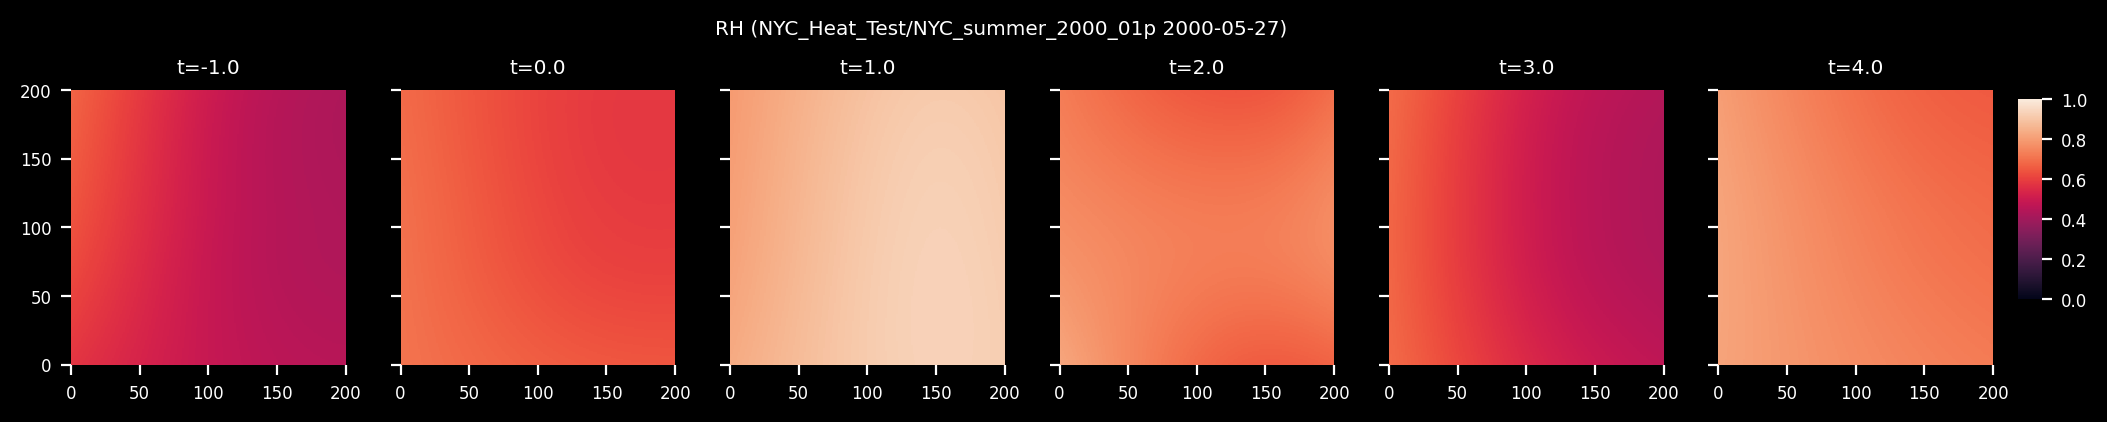

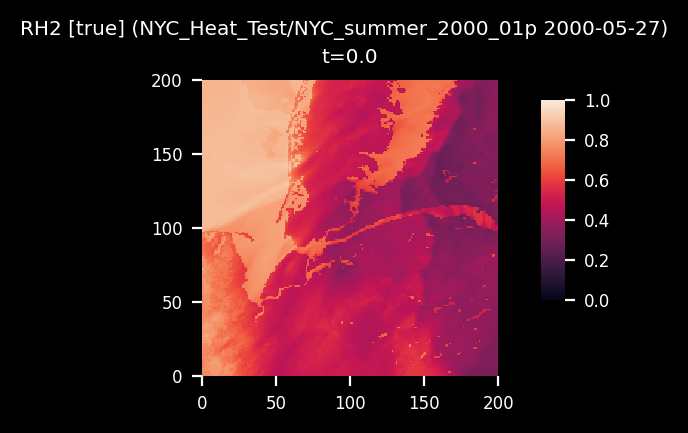

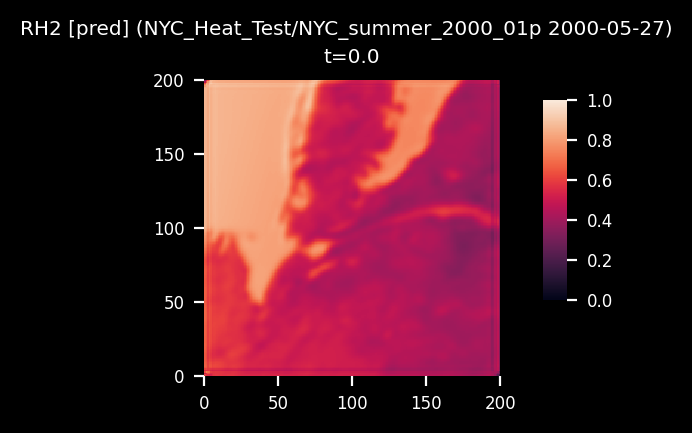

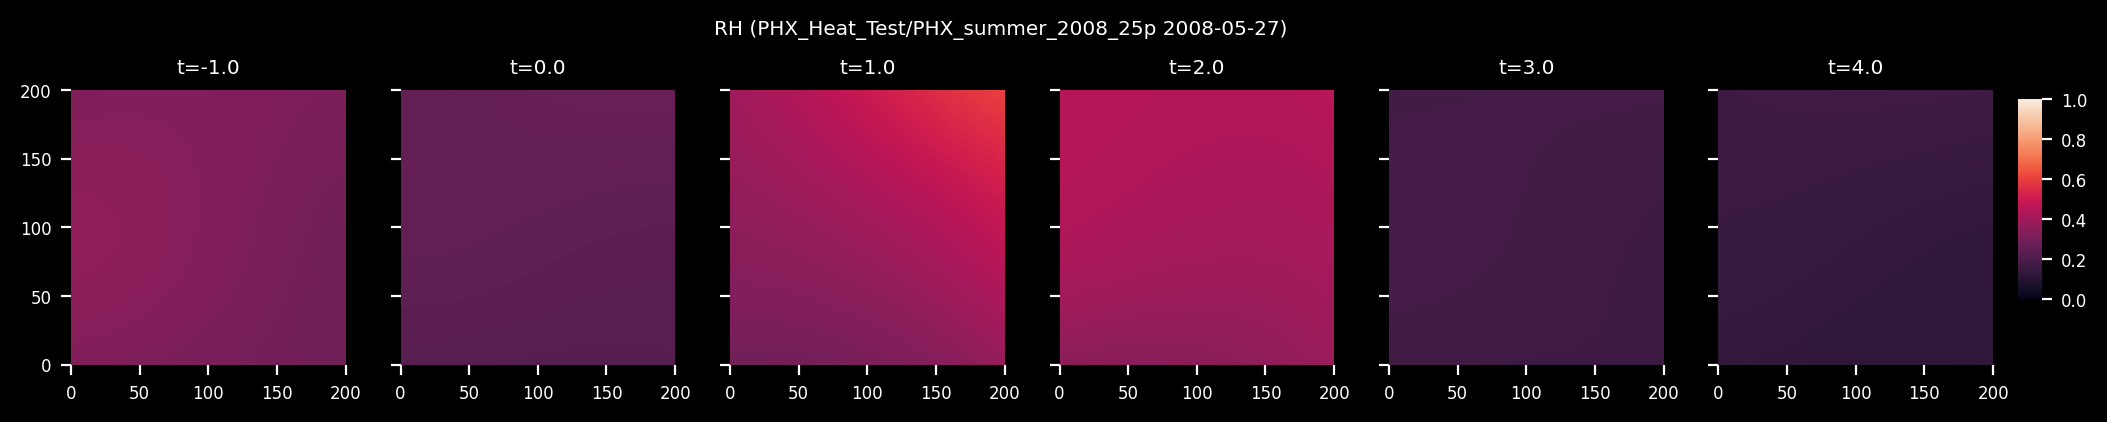

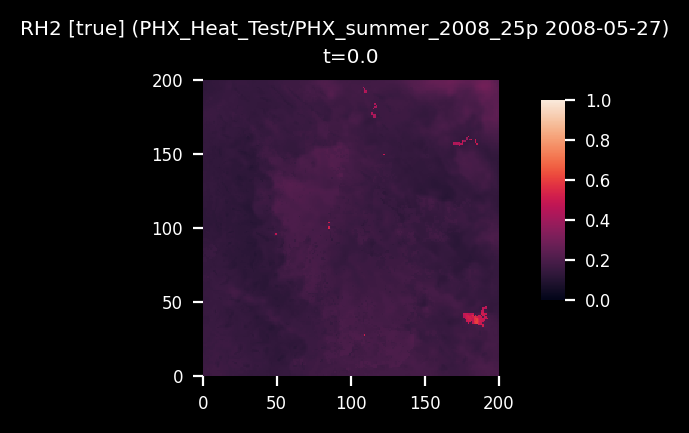

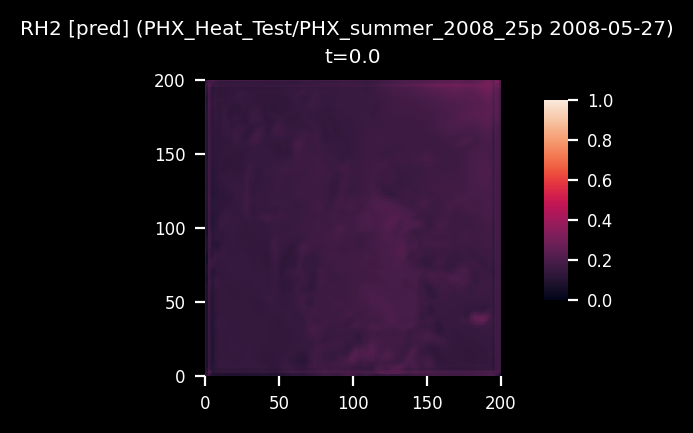

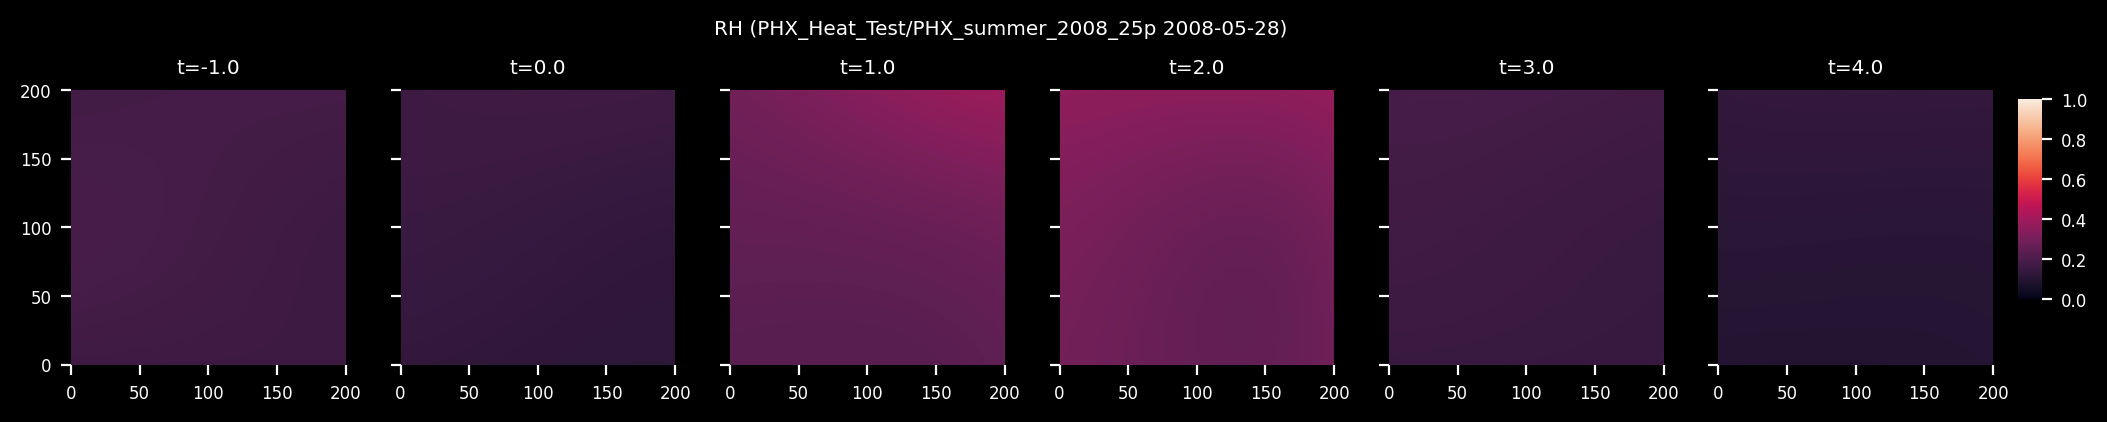

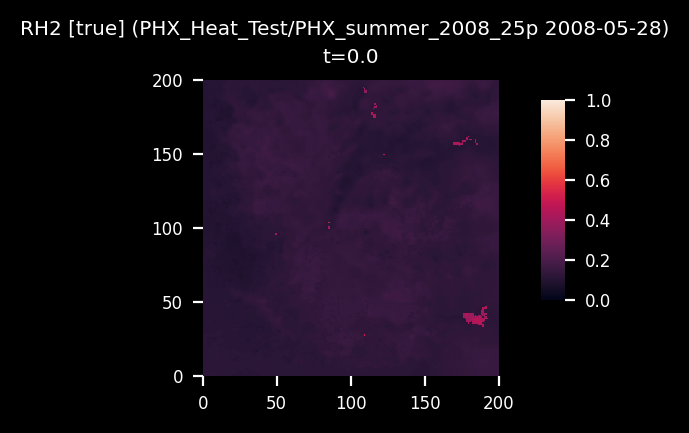

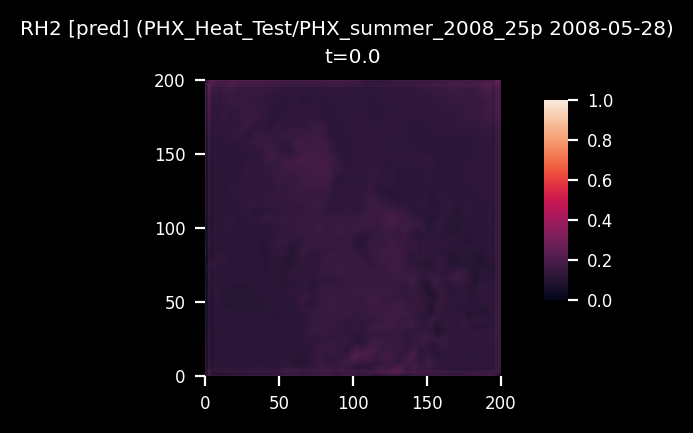

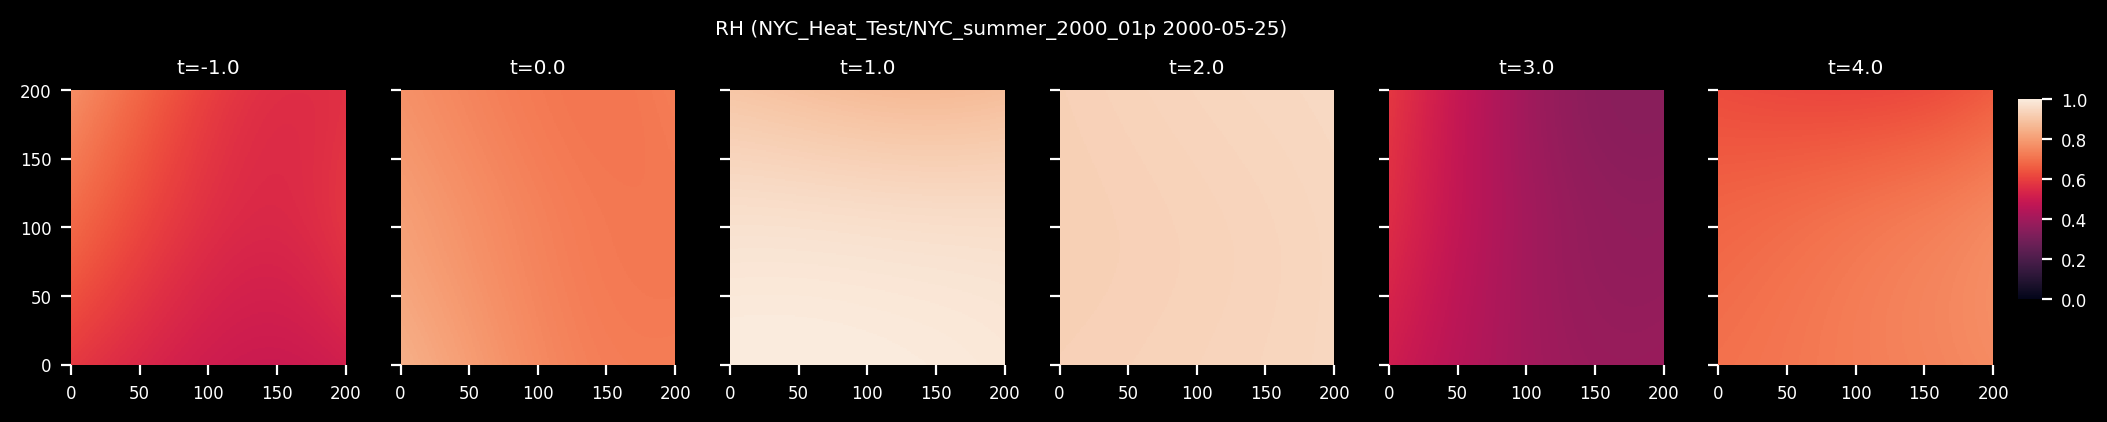

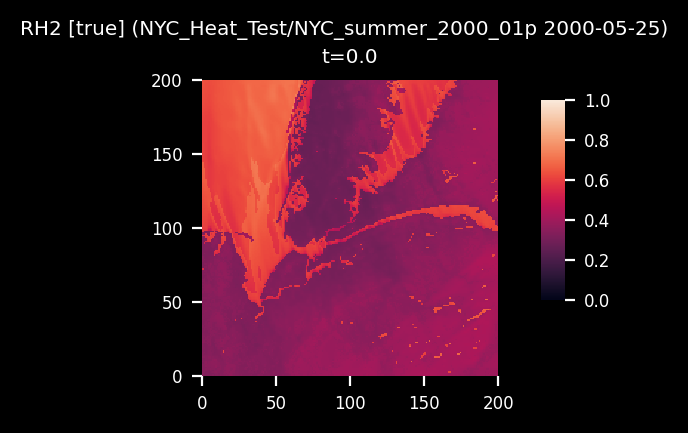

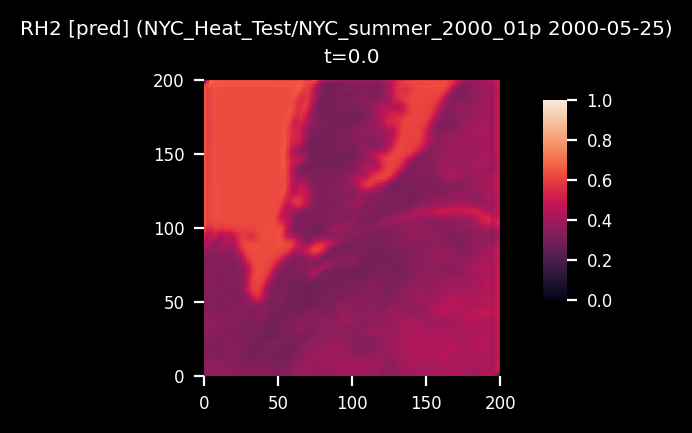

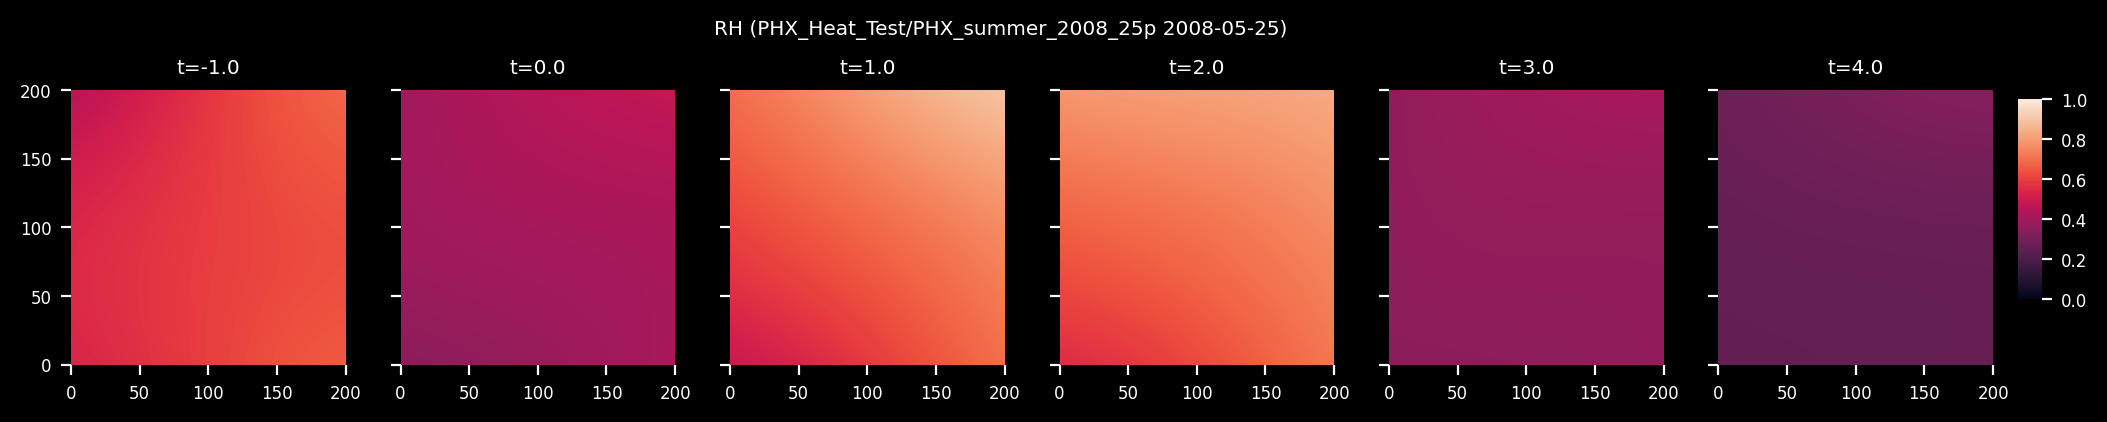

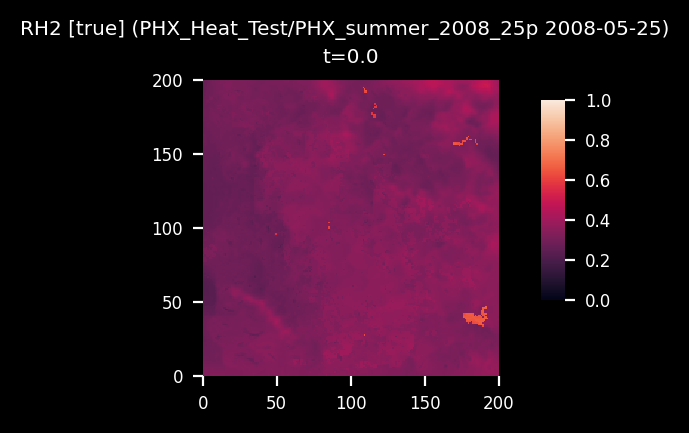

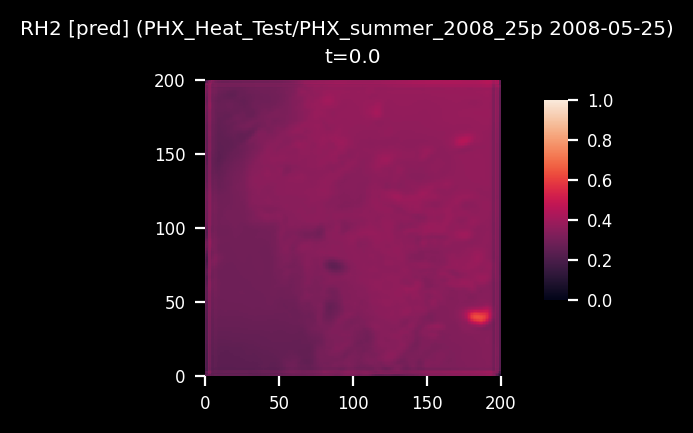

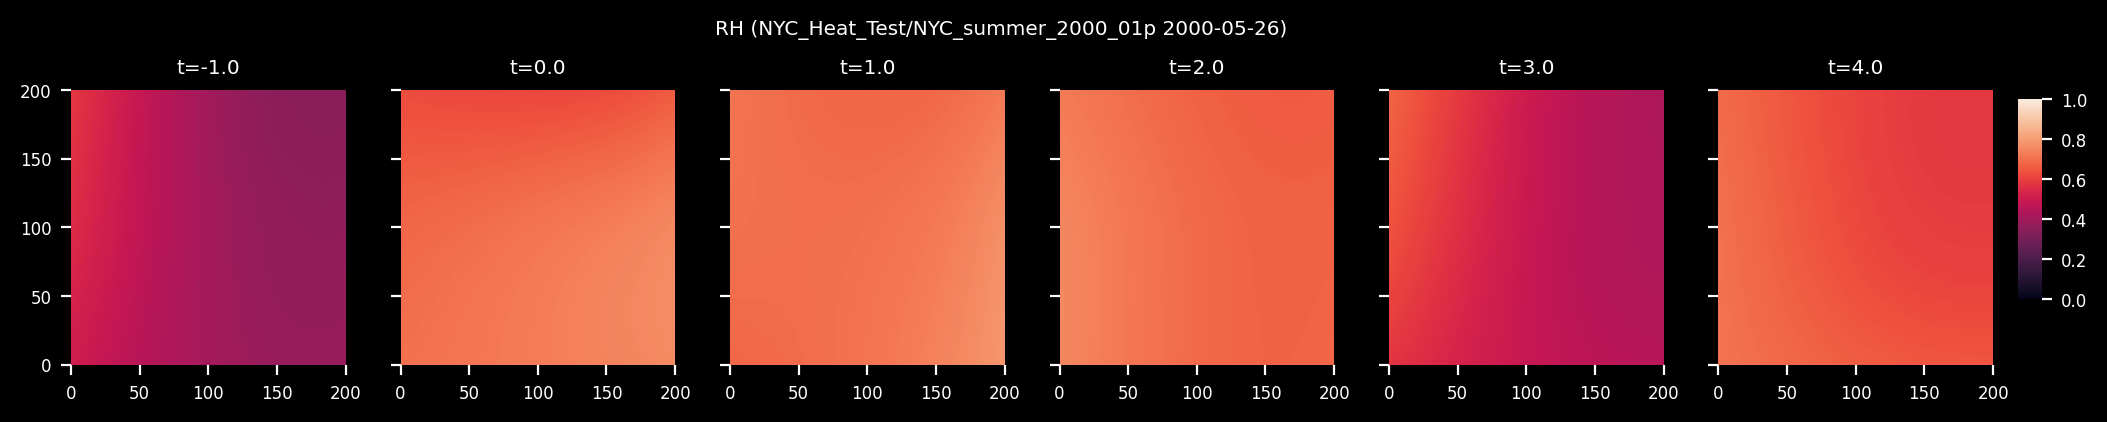

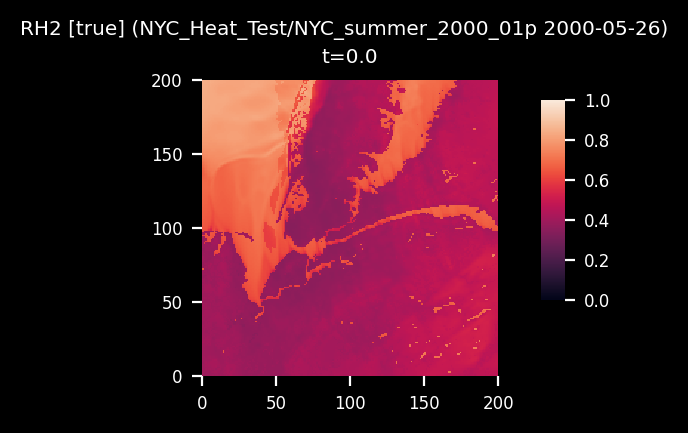

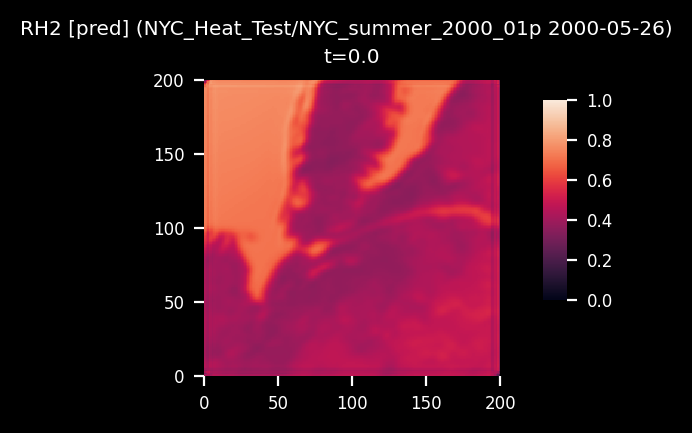

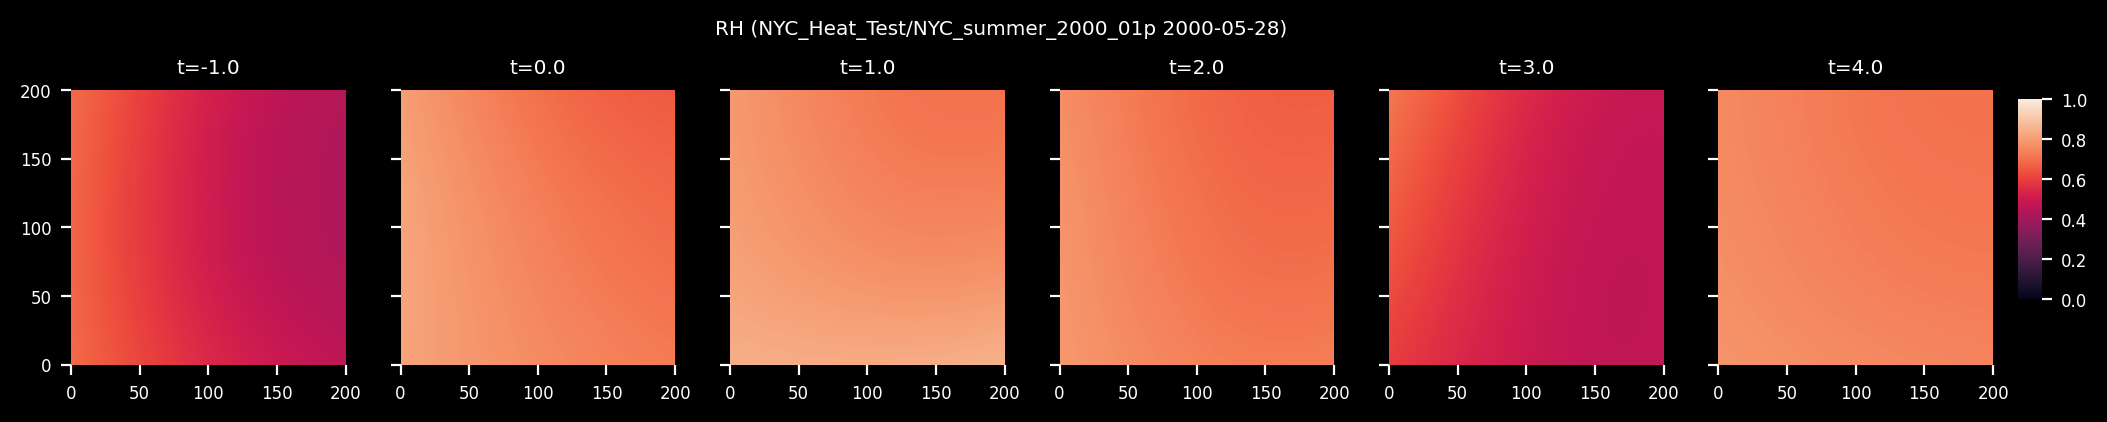

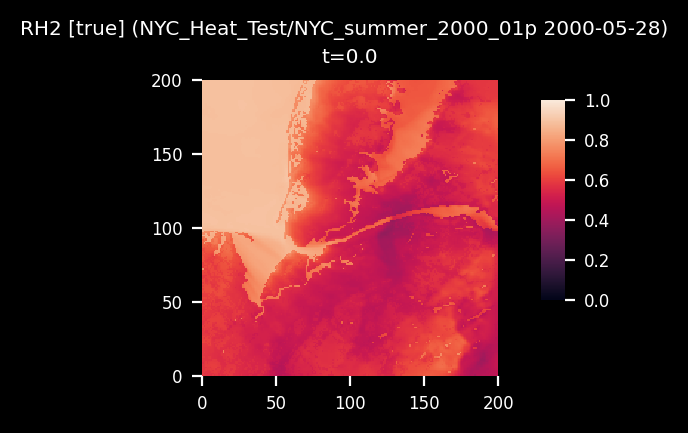

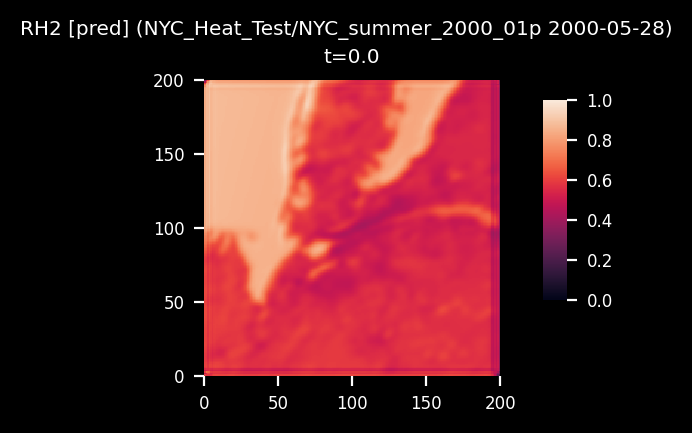

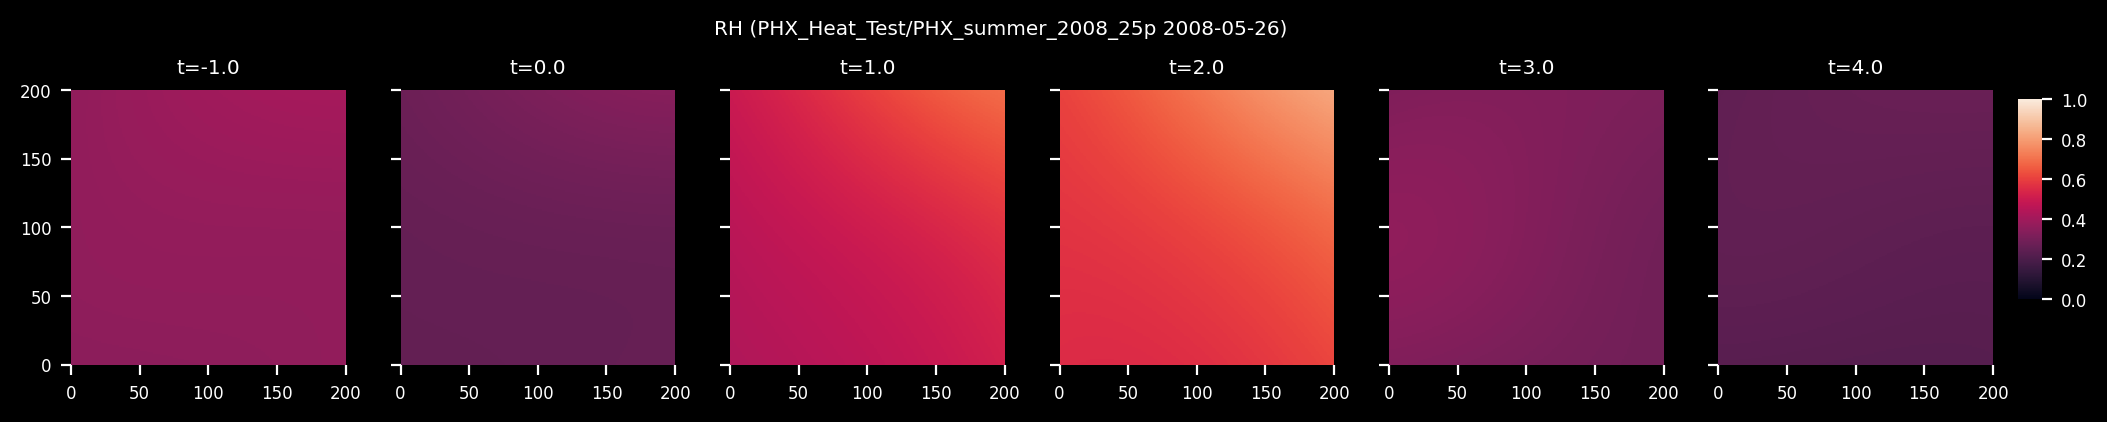

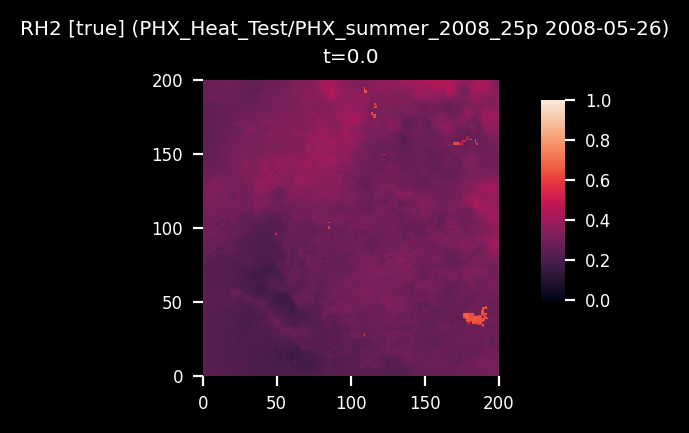

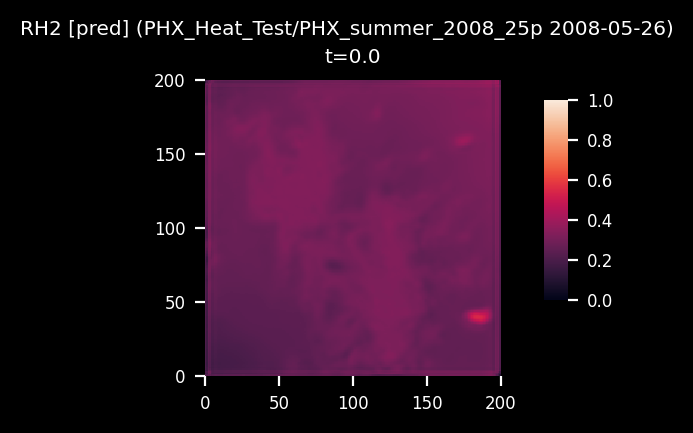

In [5]:
# Plot results
input_batch, label_batch = next(iter(val_ds))
pred_batch = model.call(input_batch)

for fig in visualizer.plot_batch(
    input_batch=input_batch,
    label_batch=label_batch,
    pred_batch=pred_batch,
    st_var=vars.Spatiotemporal.RH,
    sto_var=vars.SpatiotemporalOutput.RH2,
    max_examples=None,
):
    fig.show()